# Convolutional neural networks (CNN)

A través de éste ejemplo, veremos la implementación y uso de CNNs, desde su construcción para un conjunto de datos pequeño, hasta conceptos importantes vistos en clase, como aumento de datos, hasta `transfer learning`y `fine tunning`

Usaremos los datos del dataset cats vs dogs.

Adaptado de [Kaggle](https://www.kaggle.com/competitions/dogs-vs-cats/data).

In [1]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import glob
import os
import pathlib
import matplotlib.image as mpimg
import random
import numpy as np
from pathlib import Path
%matplotlib inline

/Users/vmac/virtualenv/ml/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Definir el dispositivo de procesamiento

In [2]:
import platform
if platform.system() == 'Darwin': #si es macOS
    av1 = torch.backends.mps.is_available()
    # this ensures that the current PyTorch installation was built with MPS activated.
    av2 = torch.backends.mps.is_built()
    if(av1==av2==True):
        print('MPS available?',av1,'MPS built?',av2)
        device = torch.device('mps')
    else:
        device = torch.device('cpu')
else:
    #Check if GPU is available
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
print("Device:",device)

MPS available? True MPS built? True
Device: mps


Ruta de las imágenes de entrenamiento y prueba (modificar para Google Colab)

Las imágenes pueden obtenerse en la carpeta compartida de [google drive](https://drive.google.com/drive/folders/1M_DzntJxmdtUCwlEPuTcp4MH2UzSnfRJ?usp=sharing), o directamente desde [Kaggle](https://www.kaggle.com/competitions/dogs-vs-cats/data), aunque éste último, no tiene los datos de validación.

In [3]:
pathlib.Path.cwd()
new_path = "../data/catvsdogs/"

PosixPath('/Users/vmac/cursos/optativas_general/notebooks2023')

## Cargar y visualizar algunas imágenes

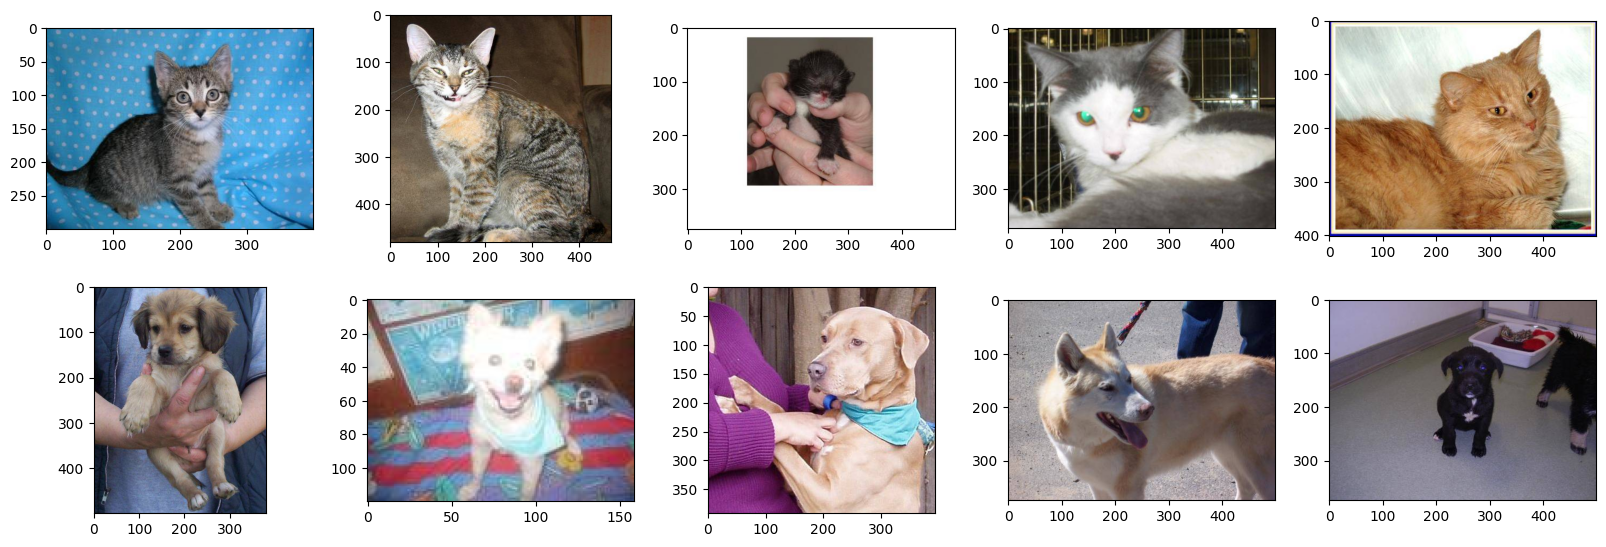

In [6]:
images = []
#Collect Cat images
for img_path in glob.glob(os.path.join(new_path,"train","cat","*.jpg"))[:5]:
    images.append(mpimg.imread(img_path))

#Collect Dog images
for img_path in glob.glob(os.path.join(new_path,"train","dog","*.jpg"))[:5]:
    images.append(mpimg.imread(img_path))

#Plot a grid of cats and Dogs
plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(images):
    plt.subplot(int(len(images) / columns + 1), columns, i + 1)
    plt.imshow(image)



## Transformaciones de las imágenes para normalizarlas y hacer *data augmentation*

In [7]:
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
# channels of images
CHANNELS = images[0].shape[2]

#Compose sequence of transformations for image
transformations_train = transforms.Compose(
    [transforms.Resize(IMAGE_SIZE),
    #transforms.CenterCrop(224),
    transforms.RandomRotation(degrees=20),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.005),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(), # convert to tensor
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.229, 0.224, 0.225])
  ])
transformations_test = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    #transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.229, 0.224, 0.225])
])


## Data loaders

In [8]:
train_set = datasets.ImageFolder(os.path.join(new_path,"train"), transform = transformations_train)
val_set = datasets.ImageFolder(os.path.join(new_path,"test"), transform = transformations_test)
labels_txt = ['cat','dog']

# Put into a Dataloader using torch library
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size =32, shuffle=True)

Veamos algunos ejemplos de las transformaciones

In [40]:
# the complete list of our images (train and test sets)
image_path_list= glob.glob(f"{new_path}/*/*/*.jpg")
# choose one at random
#random_image_path = random.choice(image_path_list)
def plot_transformed_images(image_paths, transform, n=3):
    #random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow((np.asarray(f)).astype(np.uint8))
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0)
            transformed_image = np.asarray(transformed_image)
            transformed_image = np.round(((transformed_image+1) / 2) * 255, 0)
            ax[1].imshow(np.uint8(np.clip(transformed_image, 0, 255)))
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")
            fig.suptitle(f"Class: {Path(image_path).parent.stem}", fontsize=16)


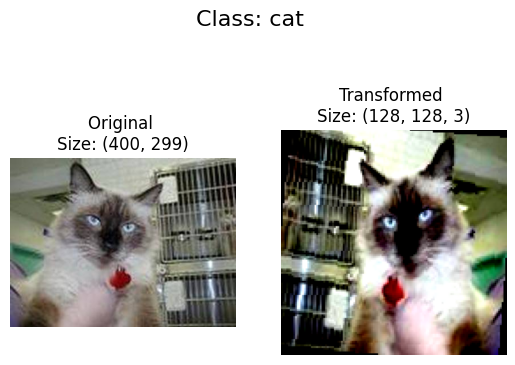

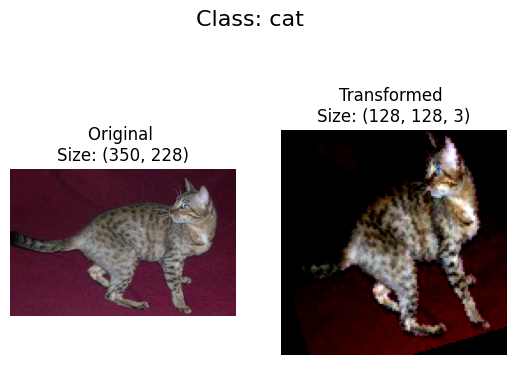

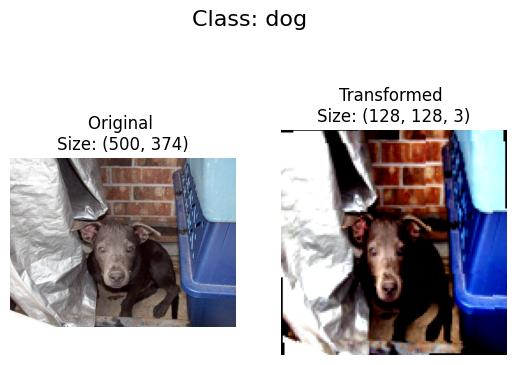

In [42]:
plot_transformed_images(image_path_list, transform=transformations_train, n=3)

## CNN entrenada con el conjunto de datos pequeño

Ver la documentación del [módulo nn](https://pytorch.org/docs/stable/nn.html) de pytorch para la descripción de los parámetros que usamos, en particular, ver [conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d) y [pooling layers](https://pytorch.org/docs/stable/nn.html#pooling-layers).

In [10]:
class ConvNet(nn.Module):
    def __init__(self, num_channels=3, num_classes=2):
        super(ConvNet, self).__init__()
        #First unit of convolution
        self.conv_unit_1 = nn.Sequential(
            nn.Conv2d(num_channels, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)) #64

        #Second unit of convolution
        self.conv_unit_2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)) #32

        #Third unit of convolution
        self.conv_unit_3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)) #16

        #Fourth unit of convolution
        self.conv_unit_4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)) #8


        #Fully connected layers
        self.fc1 = nn.Linear(8*8*128, 128)
        self.fc2 = nn.Linear(128, 1)
        self.final = nn.Sigmoid()


    def forward(self, x):
        out = self.conv_unit_1(x)
        out = self.conv_unit_2(out)
        out = self.conv_unit_3(out)
        out = self.conv_unit_4(out)

        #Reshape the output
        out = out.view(out.size(0),-1)
        out = self.fc1(out)
        out = self.fc2(out)
        out  = self.final(out)

        return(out)


### Función para evaluar el modelo en un conjunto de datos determinado por el `data_loader`

In [11]:
def evaluate(model,data_loader):
    loss = []
    correct = 0
    with torch.no_grad():
            for images, labels in data_loader:
                images = images.to(device)
                labels = labels.to(device)

                model.eval()

                output = model(images)

                predicted = output > 0.5
                correct += (labels.reshape(-1,1) == predicted.reshape(-1,1)).float().sum()

                #Clear memory
                del([images,labels])

    print('Val Accuracy: {}/{} ({:.3f}%)\n'.format(correct, len(data_loader.dataset), 100. * correct / len(data_loader.dataset)))

### Entrenamiento y validación

In [48]:
num_epochs = 10
loss_function = nn.BCELoss()  #Binary Crosss Entropy Loss
model = ConvNet(num_channels=CHANNELS)
model.to(device)
adam_optimizer = torch.optim.Adam(model.parameters(), lr= 0.001)

# Train the model
total_step = len(train_loader)
print("Total Batches:",total_step)

for epoch in range(num_epochs):
  model.train()
  train_loss = 0
  for i, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)

    # Forward pass
    outputs = model(images)
    loss = loss_function(outputs.float(), labels.float().view(-1,1))

    # Backward and optimize
    adam_optimizer.zero_grad()
    loss.backward()
    adam_optimizer.step()
    train_loss += loss.item()* labels.size(0)

    #After each epoch print Train loss and validation loss + accuracy
  print ('Epoch [{}/{}], Loss: {:.4f}\n' .format(epoch+1, num_epochs, loss.item()))
  #Evaluate model after each training epoch
  evaluate(model,val_loader)


Total Batches: 625
Epoch [1/10], Loss: 0.6555

Val Accuracy: 3207.0/5000 (64.140%)

Epoch [2/10], Loss: 0.6897

Val Accuracy: 3715.0/5000 (74.300%)

Epoch [3/10], Loss: 0.4460

Val Accuracy: 4081.0/5000 (81.620%)

Epoch [4/10], Loss: 0.2885

Val Accuracy: 3999.0/5000 (79.980%)

Epoch [5/10], Loss: 0.5213

Val Accuracy: 4248.0/5000 (84.960%)

Epoch [6/10], Loss: 0.3241

Val Accuracy: 4307.0/5000 (86.140%)

Epoch [7/10], Loss: 0.3042

Val Accuracy: 4259.0/5000 (85.180%)

Epoch [8/10], Loss: 0.4361

Val Accuracy: 4375.0/5000 (87.500%)

Epoch [9/10], Loss: 0.3158

Val Accuracy: 4431.0/5000 (88.620%)

Epoch [10/10], Loss: 0.3478

Val Accuracy: 4322.0/5000 (86.440%)



## Transfer learning

Usaremos un modelo pre-entrenado usando el  módulo de `pytorch` (ver la [documentación](https://pytorch.org/vision/stable/models.html#classification)).

In [15]:
# Download the pretrained model
new_model = models.resnet18(weights='IMAGENET1K_V1')#weights=True)
print(new_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Congelamos las capas del modelo y solo se entrenará la capa de clasificación

In [16]:
# Freeze model weights
for param in new_model.parameters():
    param.requires_grad = False

print(new_model.fc)

Linear(in_features=512, out_features=1000, bias=True)


Definimos nuestra capa de clasificación para re-entrenar (puedes probar con otras arquitecturas y ver si hay mejora).

In [17]:
new_model.fc = nn.Sequential(
                      nn.Linear(new_model.fc.in_features, 1),
                      nn.Sigmoid())

In [145]:
#new_model.fc = nn.Sequential(
#                      nn.Linear(new_model.fc.in_features, 256),
#                      nn.ReLU(),
#                      nn.Dropout(0.4),
#                      nn.Linear(256, 1),
#                      nn.Sigmoid())


In [18]:
# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in new_model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in new_model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

11,177,025 total parameters.
513 training parameters.


### Fine-tunning con el modelo pre-entrenado

In [19]:
#Define epochs, optimizer and loss function
num_epochs = 10
loss_function = nn.BCELoss()  #Binary Crosss Entropy Loss
new_model.to(device)
adam_optimizer = torch.optim.Adam(new_model.parameters(), lr= 0.001)

# Train the model
total_step = len(train_loader)
print("Total Batches:",total_step)

for epoch in range(num_epochs):
    new_model.train()
    train_loss = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = new_model(images)
        loss = loss_function(outputs.float(), labels.float().view(-1,1))

        # Backward and optimize
        adam_optimizer.zero_grad()
        loss.backward()
        adam_optimizer.step()
        train_loss += loss.item()* labels.size(0)

    #After each epoch print Train loss and validation loss + accuracy
    print ('Epoch [{}/{}], Loss: {:.4f}' .format(epoch+1, num_epochs, loss.item()))

    #After each epoch evaluate model
    evaluate(new_model,val_loader)


Total Batches: 625
Epoch [1/10], Loss: 0.3013
Val Accuracy: 4549.0/5000 (90.980%)

Epoch [2/10], Loss: 0.1741
Val Accuracy: 4566.0/5000 (91.320%)

Epoch [3/10], Loss: 0.1635
Val Accuracy: 4551.0/5000 (91.020%)

Epoch [4/10], Loss: 0.3288
Val Accuracy: 4607.0/5000 (92.140%)

Epoch [5/10], Loss: 0.2463
Val Accuracy: 4598.0/5000 (91.960%)

Epoch [6/10], Loss: 0.2354
Val Accuracy: 4571.0/5000 (91.420%)

Epoch [7/10], Loss: 0.1835
Val Accuracy: 4606.0/5000 (92.120%)

Epoch [8/10], Loss: 0.5920
Val Accuracy: 4556.0/5000 (91.120%)

Epoch [9/10], Loss: 0.4482
Val Accuracy: 4625.0/5000 (92.500%)

Epoch [10/10], Loss: 0.1348
Val Accuracy: 4600.0/5000 (92.000%)



### Evaluar imágenes del conjunto de validación

En éste caso, creo un `Data Loader` para éste conjunto de datos, y defino un tamaño de batch pequeño, pero eso puede modificarse. También puede modificarse el código para pasar directamente el archivo de la imágen.

In [146]:
# the complete list of our images (train and test sets)
imageVal_path_list= glob.glob(f"{new_path}/validation/*/*.jpg")
#len(imageVal_path_list)
valtest_set = datasets.ImageFolder(os.path.join(new_path,"validation"), transform = transformations_test)
valtest_loader = torch.utils.data.DataLoader(valtest_set, batch_size =5, shuffle=True)

Defino una función para evaluar datos de validación desde el data loader. Observa que solo ejecuta un batch.

In [93]:
def evaluate_valdata(model, loader):
    preds = []
    with torch.no_grad():
        images, labels = next(iter(loader))
        images = images.to(device)
        labels = labels.to(device)
        model.eval()
        output = model(images)

        predicted = output > 0.5

        preds.append(predicted.int())
    return images, labels, preds

Predecir datos nuevos...

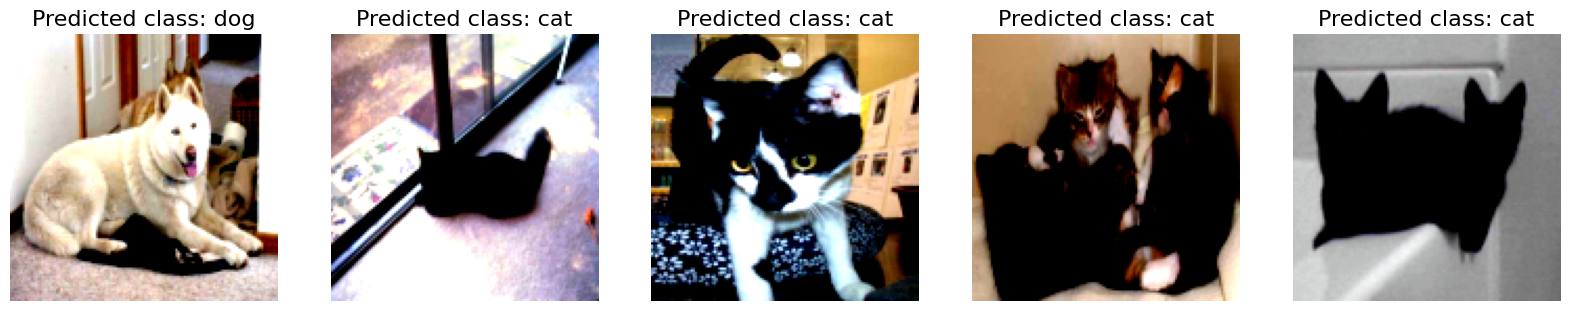

In [144]:
from itertools import chain

im, lab, preds = evaluate_valdata(new_model,valtest_loader)
preds = list(chain.from_iterable(preds)) #vectorizar las etiquetas devueltas
pred_lab = []
pred_imgs = []
for i, lab in enumerate(preds):
    val = lab.cpu().numpy().astype(int)
    pred_lab.append(labels_txt[val[0]])
    temp=im[i].permute(1, 2, 0)
    val_image = temp.cpu().numpy()
    pred_imgs.append(np.round(((val_image+1) / 2) * 255, 0))
    
# visualizar las predicciones
plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(pred_imgs):
    plt.subplot(int(len(pred_imgs) / columns + 1), columns, i + 1)
    plt.axis("off")
    plt.title(f"Predicted class: {pred_lab[i]}", fontsize=16)
    plt.imshow(np.uint8(np.clip(image, 0, 255)));

    #plt.imshow(image)